In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

NUMBER_OF_B_QUANTILES = 4

## Compute Gnocchi and B-values at a set of positive and negative enhancers linked to genes that are known to be under negative selection or no selection, respectively


In [2]:
import pandas as pd
import numpy as np

from shell import shell 
from colorize import print_string_as_info
from aggregate import aggregate

def get_header(filename):
  with open(filename) as fh: 
    header = fh.readline().strip().split('\t')
  return header

def intersect(a_filename, b_filename, intersect_filename): 
  cmd = (
    f'bedtools intersect'
    f" -a <(tail -n +2 {a_filename})" # contains header
    f" -b <(cat {b_filename})"        # does not contain header
    f' -wao -f 0.5'
    f' > {intersect_filename}'
  )
  shell(cmd)
  print_string_as_info(f'Wrote {intersect_filename}')

  a_file_header = get_header(a_filename)               # contains header
  b_file_header = ['B_chrom', 'B_start', 'B_end', 'B'] # does not contain header

  return a_file_header, b_file_header

def set_column_dtypes(df, column_dtypes, log=False): 
  for col, dtype in column_dtypes.items(): 
    df[col] = df[col].astype(dtype)

  if log: print(dict(df.dtypes))
  return df 

def make_scores_numeric(df): 
  # we don't want to include enhancers that don't overlap any windows with B-values
  df = df[df['B_chrom'] != '.'] 

  # having removed records where 'B_chrom' is '.', we can now convert the column to a float
  df = set_column_dtypes(
    df,   
    column_dtypes = {
      'B': float,
    }
  )

  return df 
  
def assign_bvalues_to_labeled_enhancers(number_of_B_quantiles=NUMBER_OF_B_QUANTILES):
  a_filename = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/labeled-enhancers.gnocchi.GC.bed'
  b_filename = f'{CONSTRAINT_TOOLS_DATA}/background-selection/CADD-B-map/bmap.hg38.bed'
  intersect_filename = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/labeled-enhancers.gnocchi.GC.bvalues.bed'

  a_file_header, b_file_header = intersect(a_filename, b_filename, intersect_filename)

  df = pd.read_csv(
    intersect_filename, 
    sep='\t',
    names=a_file_header + b_file_header + ['enhancer_BWindow_overlap'],
  )

  df = make_scores_numeric(df)

  # though unlikely, some enhancers may intersect multiple B-windows, 
  # so let's group by enhancer, and aggregare scores over all B-windows in the group
  df = aggregate(
    df, 
    group_columns = a_file_header,
    aggregation_functions = {
      'B': [np.max],
    }
  )

  df = df.rename(columns={'max B': 'B'})

  df.to_csv(
    f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/labeled-enhancers.gnocchi.GC.bvalues.aggregated.bed', 
    sep='\t', 
    index=False
  )

  df['B_range'] = pd.qcut(df['B'], q=number_of_B_quantiles, labels=None, retbins=False)

  return df

pd.set_option('display.max_columns', 100)

LABELED_EXAMPLES = assign_bvalues_to_labeled_enhancers()
LABELED_EXAMPLES

Wrote /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/benchmark-genome-wide-predictions/chen-et-al-2022/labeled-enhancers.gnocchi.GC.bvalues.bed
<ipython-input-2-dc7ac7c2df01>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(dtype)


,enhancer_chrom,enhancer_start,enhancer_end,gene,enhancer,Haploinsufficient,MGI essential,OMIM dominant,LOEUF constrained,Olfactory,LOEUF unconstrained,max chen_score,max corrected_chen_score,max filtered_chen_score,mean window_GC_content,truly constrained,B,B_range
0,chr1,1536220,1537020,TMEM240,chr1-1536220-1537020,False,False,True,False,False,False,5.401829,1.029468,3.238727,0.570806,True,0.651,"(0.633, 0.776]"
1,chr1,1554620,1555020,ATAD3A,chr1-1554620-1555020,False,False,True,False,False,False,4.059724,0.304463,1.584306,0.569781,True,0.652,"(0.633, 0.776]"
2,chr1,2128961,2129161,GABRD,chr1-2128961-2129161,False,True,True,True,False,False,3.499737,0.045254,3.531299,0.565593,True,0.841,"(0.776, 0.878]"
3,chr1,2268561,2268761,SKI,chr1-2268561-2268761,False,True,True,True,False,False,5.007183,1.077828,2.657948,0.547951,True,0.847,"(0.776, 0.878]"
4,chr1,2545161,2545361,PANK4,chr1-2545161-2545361,False,False,True,False,False,False,2.775673,-0.264937,3.898165,0.557988,True,0.840,"(0.776, 0.878]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3964,chr9,136985948,136986348,ABCA2,chr9-136985948-136986348,False,False,False,True,False,False,1.520249,-1.361364,2.440721,0.593556,True,0.567,"(0.535, 0.633]"
3965,chr9,137056348,137056748,C8G,chr9-137056348-137056748,False,False,False,False,False,True,1.791253,-1.153519,1.921103,0.588361,False,0.555,"(0.535, 0.633]"
3966,chr9,137138948,137139148,ANAPC2,chr9-137138948-137139148,False,True,False,True,False,False,7.713586,2.154798,3.809813,0.583129,True,0.556,"(0.535, 0.633]"
3967,chr9,137446948,137447348,NSMF,chr9-137446948-137447348,False,False,True,False,False,False,3.799187,0.305548,3.857012,0.557292,True,0.536,"(0.535, 0.633]"


## Gnocchi differentiates labeled enhancers less when background selection is stronger (smaller B)

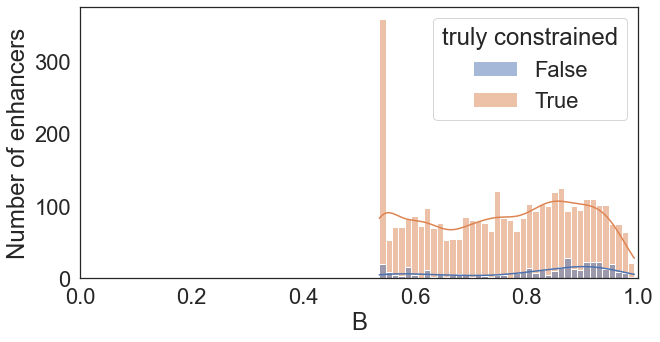

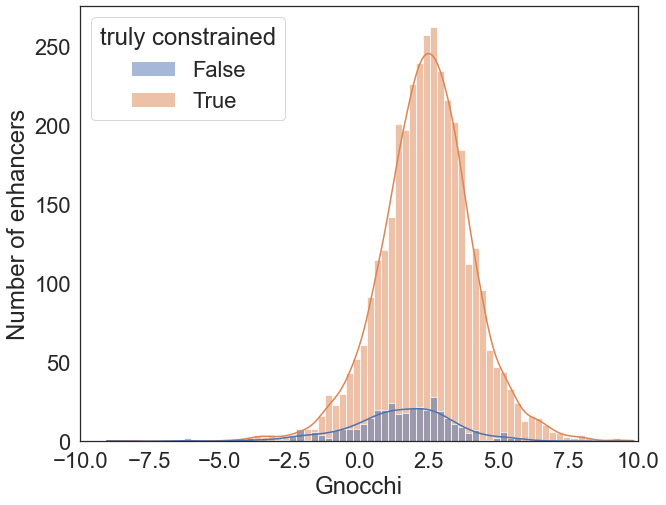

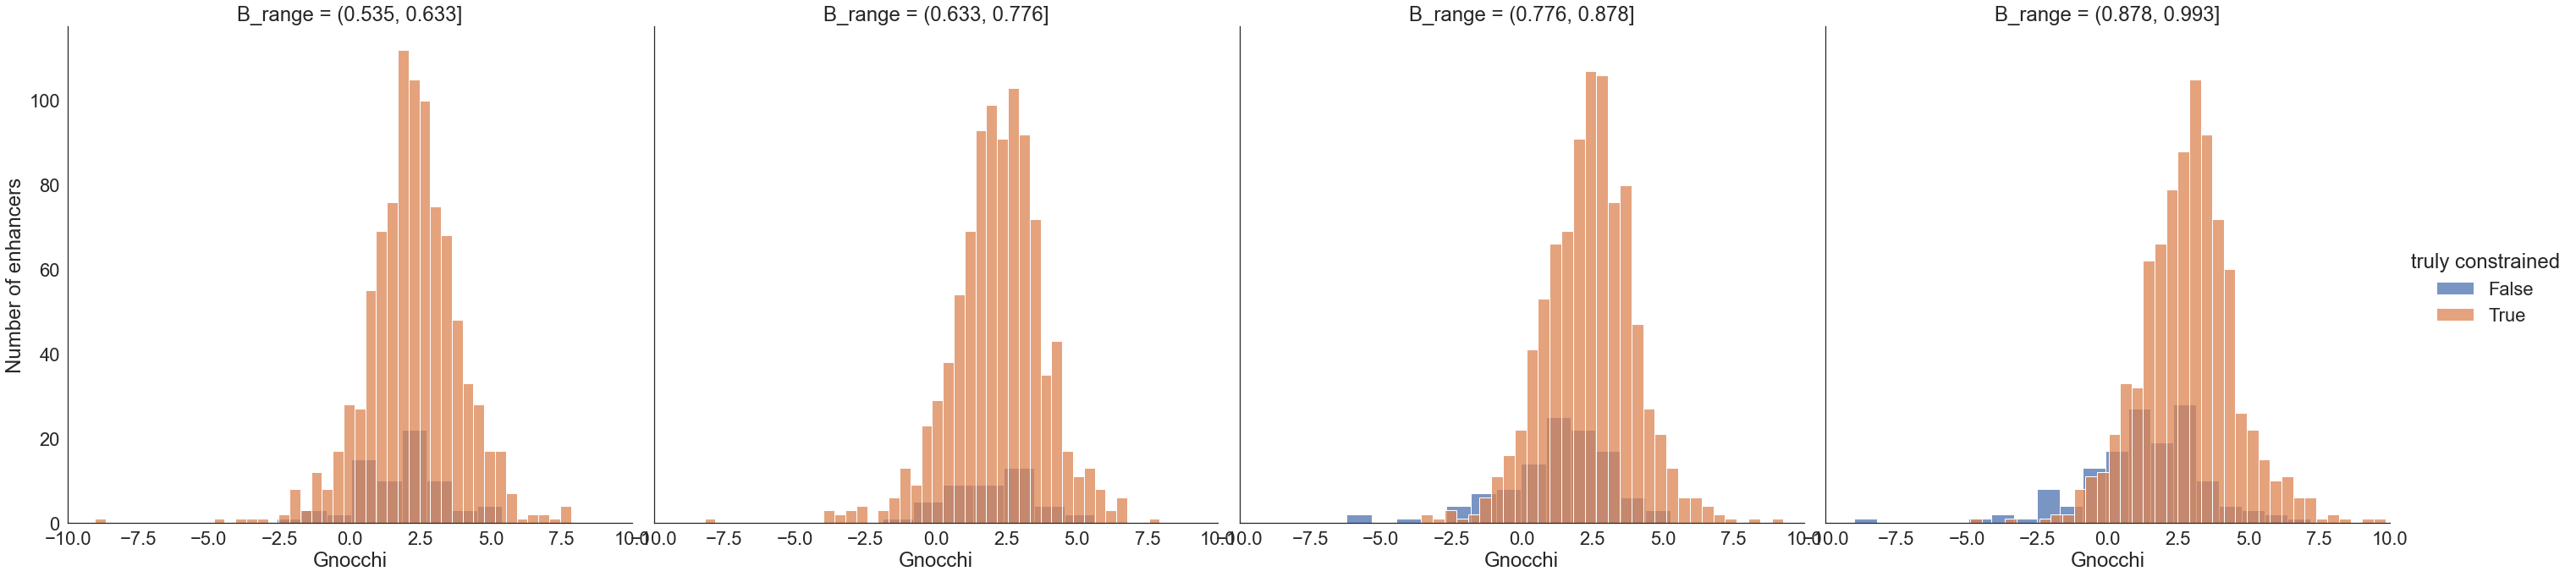

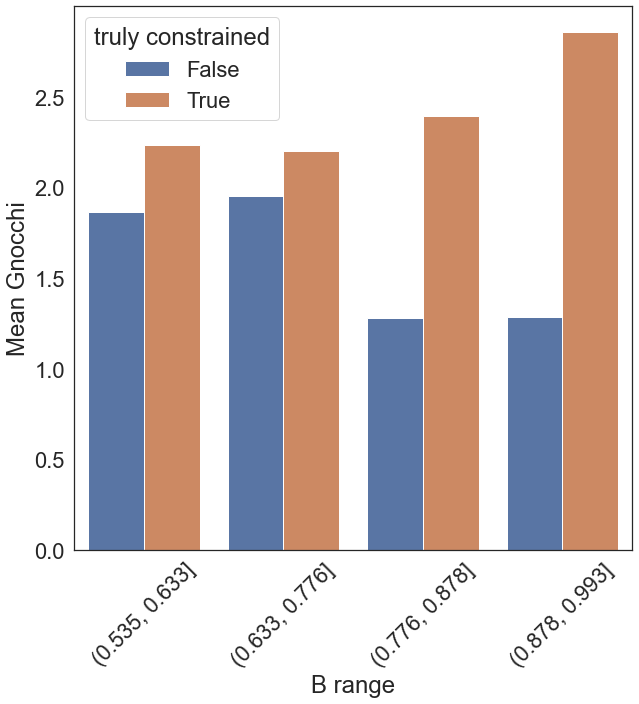

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (10, 10)

import seaborn as sns

sns.set_theme(style='white', font_scale=2)

def plot_Gnocchi_and_B(df): 
  plt.figure(figsize=(10, 5))
  sns.histplot(data=df, x='B', hue='truly constrained', kde=True, bins=40)
  plt.xlim(0, 1)
  plt.ylabel('Number of enhancers')

  plt.figure(figsize=(10, 8))
  sns.histplot(data=df, x='max chen_score', hue='truly constrained', kde=True)
  plt.xlabel('Gnocchi')
  plt.ylabel('Number of enhancers')
  plt.xlim(-10, 10)
  plt.show()

  g = sns.FacetGrid(df, col='B_range', hue='truly constrained', height=10, aspect=1)
  g.map(sns.histplot, 'max chen_score')
  g.set_ylabels("Number of enhancers")
  g.set_xlabels('Gnocchi')
  g.add_legend()
  g.set(xlim=(-10, 10))
  plt.show()

  df = aggregate(
    df, 
    group_columns = ['B_range', 'truly constrained'],
    aggregation_functions = {
      'max chen_score': [np.mean],
    }
  )
  plt.figure(figsize=(10, 10))
  sns.barplot(data=df, x='B_range', y='mean max chen_score', hue='truly constrained')
  plt.xlabel('B range')
  plt.ylabel('Mean Gnocchi')
  plt.xticks(rotation=45)
  plt.show()

plot_Gnocchi_and_B(LABELED_EXAMPLES)

## Baseline classifier

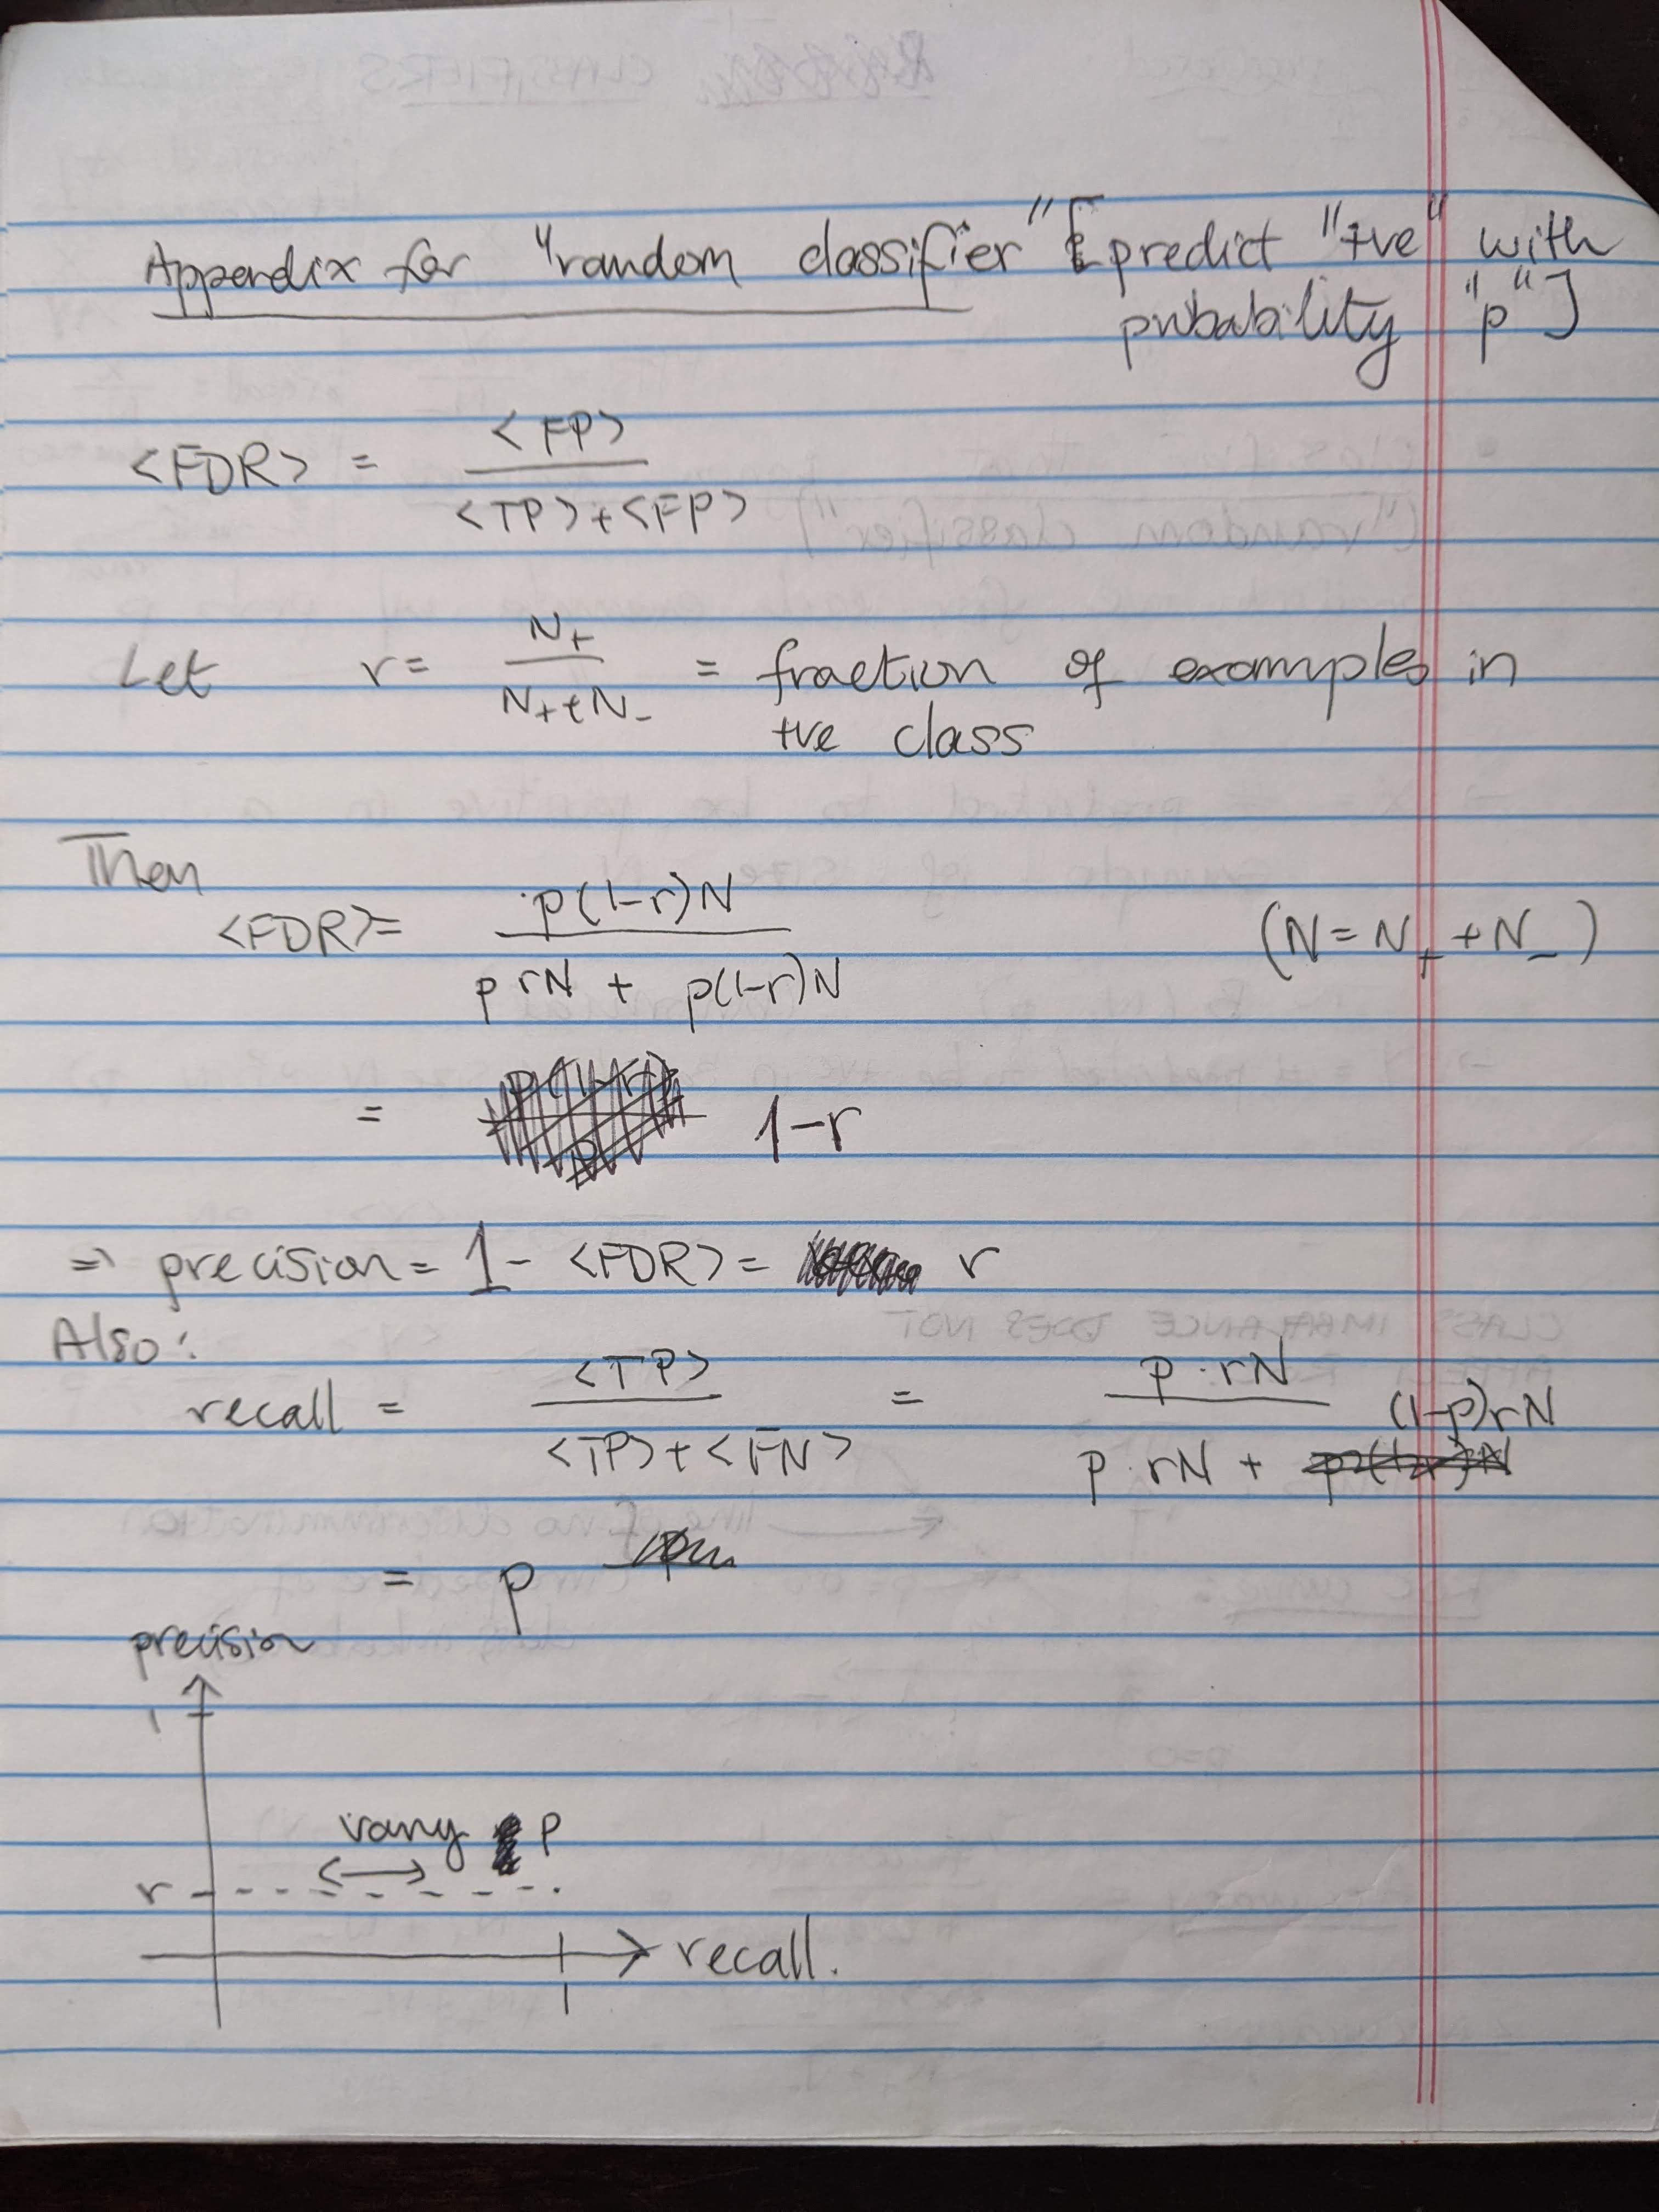

In [4]:
from IPython.display import Image # type: ignore
Image(filename='precision_recall_random_classifier.jpg', width=600)

## Background selection negatively impacts a Gnocchi-based classifier

<ipython-input-6-f9e8c353d17c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predicted to be constrained'] = df[score] > score_threshold


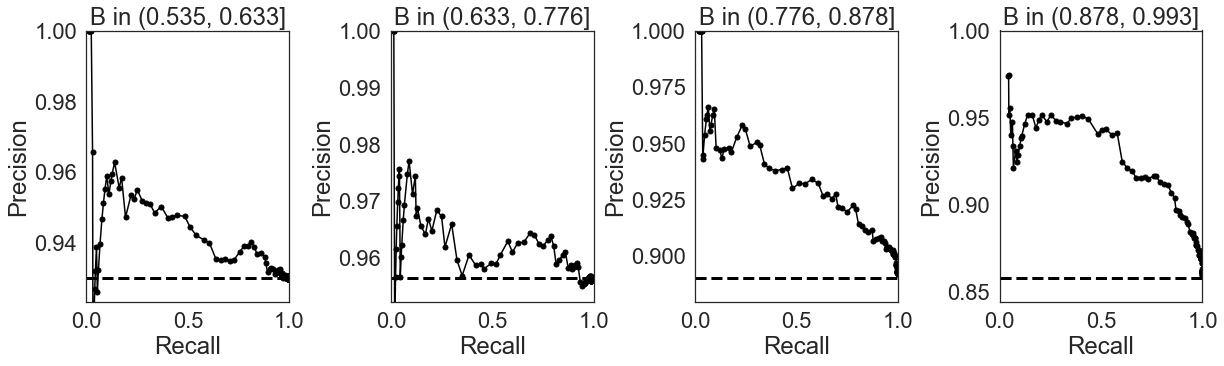

In [6]:
def predict_and_compute_precision_recall_under_naive_classifier(df, score, score_threshold):
  df['predicted to be constrained'] = df[score] > score_threshold
  TP = df[(df['truly constrained'] == True) & (df['predicted to be constrained'] == True)].shape[0]
  FP = df[(df['truly constrained'] == False) & (df['predicted to be constrained'] == True)].shape[0]
  FN = df[(df['truly constrained'] == True) & (df['predicted to be constrained'] == False)].shape[0]
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  return precision, recall

def plot_precision_recall_under_naive_classifier(df, score, score_thresholds, color, linestyle, label, axis=None): 
  precision_recall = [
    predict_and_compute_precision_recall_under_naive_classifier(
      df, 
      score, 
      score_threshold
    )
    for score_threshold in score_thresholds
  ]
  precisions, recalls = zip(*precision_recall)
  (axis if axis else plt).plot(
    recalls, 
    precisions, 
    label=label, 
    color=color,
    linestyle=linestyle,
    marker='o',
    markersize=5
  )
  
def compute_positive_fraction(df):
  # this is "r" in the baseline-classifier theory 
  number_negative_examples = df['truly constrained'].value_counts().loc[False]
  number_positive_examples = df['truly constrained'].value_counts().loc[True]
  return number_positive_examples / (number_negative_examples + number_positive_examples)

def plot_precision_recall_with_baseline(df, color, title, axis): 
  plot_precision_recall_under_naive_classifier(
    df, 
    score='max chen_score',
    score_thresholds=np.arange(-4, 6, 0.1),
    color=color,
    linestyle='-',
    label=None,
    axis=axis
  )  

  # random classifier
  r = compute_positive_fraction(df)
  axis.plot([0, 1], [r, r], linestyle='--', linewidth=3, color=color)
  
  axis.set_xlabel('Recall')
  axis.set_ylabel('Precision')
  axis.set_xlim(0, 1)
  axis.set_ylim(r - (1-r)*0.1, 1)
  axis.set_title(title)

def plot_precision_recall_all(df): 
  fig, axs = plt.subplots(1, NUMBER_OF_B_QUANTILES, figsize=(20, 5))
  plt.subplots_adjust(wspace=0.5)

  for i, b_quantile in enumerate(sorted(df['B_range'].unique())): 
    df_b_range = df[df['B_range'] == b_quantile]
    plot_precision_recall_with_baseline(
      df_b_range, 
      color='black',
      title=f'B in {b_quantile}',
      axis=axs[i]
    ) 
    
plot_precision_recall_all(LABELED_EXAMPLES)